<a href="https://colab.research.google.com/github/shoushinkk/-Machine-Learning/blob/main/%D0%9F%D1%80%D0%BE%D0%BA%D0%BE%D0%BF%D0%B5%D0%BD%D0%BA%D0%BE%D0%9A_%D0%9F%D0%A09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28*28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальна кількість епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковому підтримці з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# Створення нейроної мережі

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
    # Робимо ми це для того, щоб
    # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
    # Приналежності вхідного об'єкта до одного з 10 класів

    return x3

In [5]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [6]:
# Екземпляр нейронної мережі
neural_net = NN(name="fashion_mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Створимо список параметрів, що оптимізуються.
    trainable_variables = nn.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігайте в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігайте в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# з тренувального датасету train_data вийміть випадкову підмножину, на якій
# відбудеться тренування. Використовуйте метод take, доступний для тренувального датасету.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 2292.8369140625, Accuracy: 0.18359375
Step: 100, Loss: 254.23419189453125, Accuracy: 0.71875
Step: 200, Loss: 238.14710998535156, Accuracy: 0.69921875
Step: 300, Loss: 220.1197967529297, Accuracy: 0.76171875
Step: 400, Loss: 147.09776306152344, Accuracy: 0.828125
Step: 500, Loss: 173.06427001953125, Accuracy: 0.77734375
Step: 600, Loss: 165.50048828125, Accuracy: 0.765625
Step: 700, Loss: 152.36065673828125, Accuracy: 0.75390625
Step: 800, Loss: 180.26791381835938, Accuracy: 0.7578125
Step: 900, Loss: 142.35873413085938, Accuracy: 0.8046875
Step: 1000, Loss: 128.3187255859375, Accuracy: 0.80859375
Step: 1100, Loss: 140.48074340820312, Accuracy: 0.83984375
Step: 1200, Loss: 141.99737548828125, Accuracy: 0.8203125
Step: 1300, Loss: 115.01689147949219, Accuracy: 0.84765625
Step: 1400, Loss: 140.01365661621094, Accuracy: 0.83984375
Step: 1500, Loss: 117.60710144042969, Accuracy: 0.8515625
Step: 1600, Loss: 128.06773376464844, Accuracy: 0.828125
Step: 1700, Loss: 129.50024414

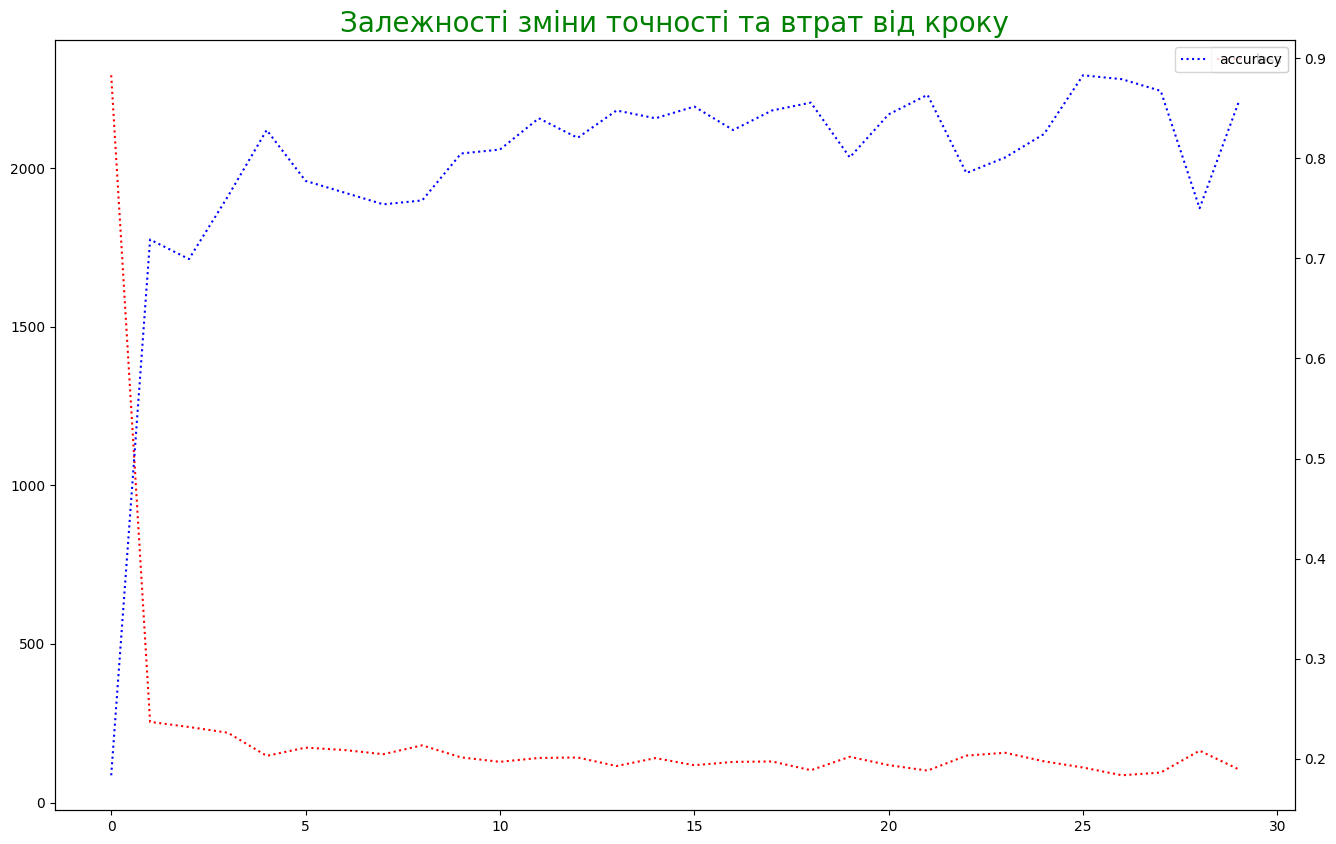

In [8]:
# Виведіть графіки залежності зміни точності та втрат від кроку
# Якщо все зроблено правильно, то точність має зростати, а втрати зменшуватися

import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

In [9]:
# Обчисліть точність навченої нейромережі

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8318333625793457


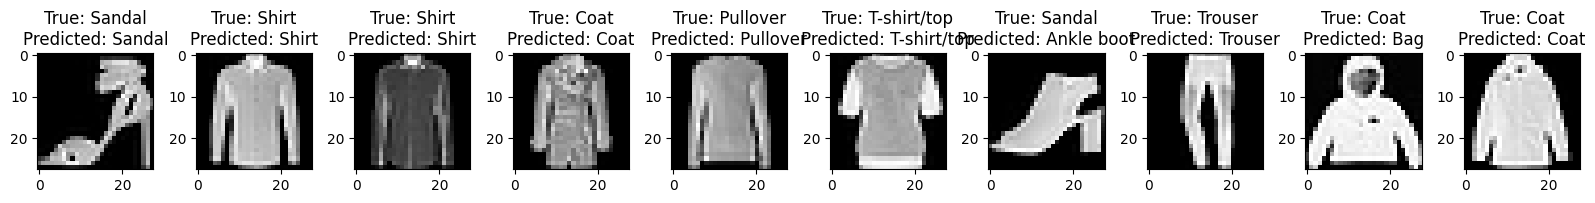

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def plot_images(images, true_labels, predicted_labels, class_names):
  plt.figure(figsize=(16,6))
  for i in range(len(images)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
  plt.tight_layout()
  plt.show()

test_indices = np.random.permutation(x_test.shape[0])[:10]
true_labels = y_test[test_indices]

predicted_labels = [np.argmax(x) for x in neural_net(x_test[test_indices])]

plot_images(x_test[test_indices], true_labels, predicted_labels, class_names)

Висновок: на практичній роботі навчилися роботі з нейронними мережами, створив нейрону мережу, перемішував тренувальні дані, обчислював точність нейроної мережі